In [ ]:
"""
nodes: speakers
edges: when they use one same word 

        --> prune: keep only E(n1,n2)>= threshold(=alpha)


"""

In [1]:
import re, itertools
import networkx as nx

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

%load_ext autoreload
%autoreload 2
import sys
sys.path.append('/Users/katiehuang/Desktop/metis/projects/onl_ds5_project_4/py')
from word_cloud import *
import importlib

## Load data and define df

In [4]:
speech_df_lemma = pd.read_pickle('../dump/speech_clean_lemma')
topic_df = pd.read_pickle('../dump/topic_df')
topic_word = pd.read_pickle('../dump/to_nx_topic_words')
speaker_label = pd.read_pickle('../dump/speaker_label_nmf')
speech_df = pd.read_pickle('../dump/speech_df_speaker')

In [7]:
# (raw transcript)
speech_df

,speaker,profession,born,age,origin,category,year,school,transcript,length,age_then
0,SIDDHARTHA MUKHERJEE,American-Indian physician,1970,50,New Delhi India,Med/Law,2018,Univ. of Southern California,I wish someone had told me at my own commenc...,14487,48
1,JESMYN WARD,American novelist,1977,43,De Lisle MS,Publish,2018,Tulane University,Persist. Be patient. Be well. Good morning....,14063,41
2,DAVID SEDARIS,American humorist,1956,64,Johnson City NY,Entertainment,2018,OBERLIN COLLEGE,"Thank you so much for having me, and for prese...",10587,62
3,NIGHT SHYAMALAN,American-Indian filmmaker,1970,50,Mahé India,Entertainment,2018,DREXEL UNIVERSITY,\nwhat's up dragons alright let's start\n\nwit...,26406,48
4,TERRY TEACHOUT,American author,1955,65,Cape Girardeau MO,Publish,2018,HAMILTON HOLT SCHOOL,"I’m supposed to keep it short, and I approve o...",6288,63
...,...,...,...,...,...,...,...,...,...,...,...
326,GUIDO CALABRESI,American-Italian judge,1932,88,Milan Italy,Med/Law,1988,CONNECTICUT COLLEGE,It's a particular honor for me to be here at t...,14101,56
327,MEREDITH MONK,American composer,1942,78,New York NY,Art,1985,SARAH LAWRENCE COLLEGE,"President Lichman, members of the faculty, alu...",9255,43
328,MARGARET ATWOOD,Canadian poet,1939,81,Ottawa Canada,Publish,1983,UNIVERSITY OF TORONTO,I am of course overjoyed to be here today in t...,11588,44
329,ALAN ALDA,American actor,1935,85,New York NY,Entertainment,1980,CONNECTICUT COLLEGE,I'm here today for a very special reason.\n\nW...,18161,45


In [8]:
import pickle
with open("../dump/common_words.txt", "rb") as f:   # Unpickling
    common_words = pickle.load(f)

In [9]:
def corpus_remove_stop_words(transcript):
    
    add_stop_words = ['like','youre','ive','im','really','id','ve','just','dont','thi','wa',
                  'say','know','make','people']

    boring_words = ['say','like','just','dont','don','im',
                      'ive','youll','youve','things','thing','youre','right','really','lot',
                      'make','know','people','way','day','class']


    add_stop_words = add_stop_words + common_words + boring_words

    stop_words = text.ENGLISH_STOP_WORDS.union(add_stop_words)

    words = transcript.split(" ")
    new_words = [x for x in words if x not in stop_words]
    new_transcript = " ".join(new_words)
    return new_transcript

In [219]:
num_rows = 40
df_unique = speech_df.copy()
df_unique.drop_duplicates(subset=['speaker'],inplace=True)
df = df_unique[['transcript','category','age','age_then']].iloc[:num_rows]
df.index = df_unique.speaker.tolist()[:num_rows]
# df

In [220]:
df['transcript_clean'] = df['transcript'].apply(corpus_remove_stop_words)

In [221]:
df.head()

,transcript,category,age,age_then,transcript_clean
SIDDHARTHA MUKHERJEE,I wish someone had told me at my own commenc...,Med/Law,50,48,I wish told commencement requirement graduat...
JESMYN WARD,Persist. Be patient. Be well. Good morning....,Publish,43,41,Persist. Be patient. Be well. Good morning....
DAVID SEDARIS,"Thank you so much for having me, and for prese...",Entertainment,64,62,"Thank having me, presenting honorary degree. I..."
NIGHT SHYAMALAN,\nwhat's up dragons alright let's start\n\nwit...,Entertainment,50,48,\nwhat's dragons alright let's start\n\nwith g...
TERRY TEACHOUT,"I’m supposed to keep it short, and I approve o...",Publish,65,63,"I’m supposed short, I approve that. Being dram..."


## Network graph

In [273]:
# Note that this cell will take longer to run as the relationship are added

speaker_word = cv_dtm(df,'transcript',add_stop_words=[])

# Prepare nodes
node_list = list(df.index)

# Prepare edges
from collections import defaultdict
speaker_word_assoc_original = defaultdict(lambda: 0)

relationships = itertools.combinations(node_list,2) 
for relationship in relationships:
    for word in speaker_word.columns:
        if (speaker_word.loc[relationship[0],word] != 0) & \
           (speaker_word.loc[relationship[1],word] != 0):
                speaker_word_assoc_original[relationship] += 1

In [278]:
# Specify the threshold for pruning
alpha = 0.18

speaker_word_assoc = speaker_word_assoc_original.copy()

min_edge = min(speaker_word_assoc.values())
max_edge = max(speaker_word_assoc.values())
for key, value in speaker_word_assoc.items():
    if value/max_edge > alpha:
        speaker_word_assoc[key] = value/max_edge
    else:
        speaker_word_assoc[key] = 0

### 1. Basic graph

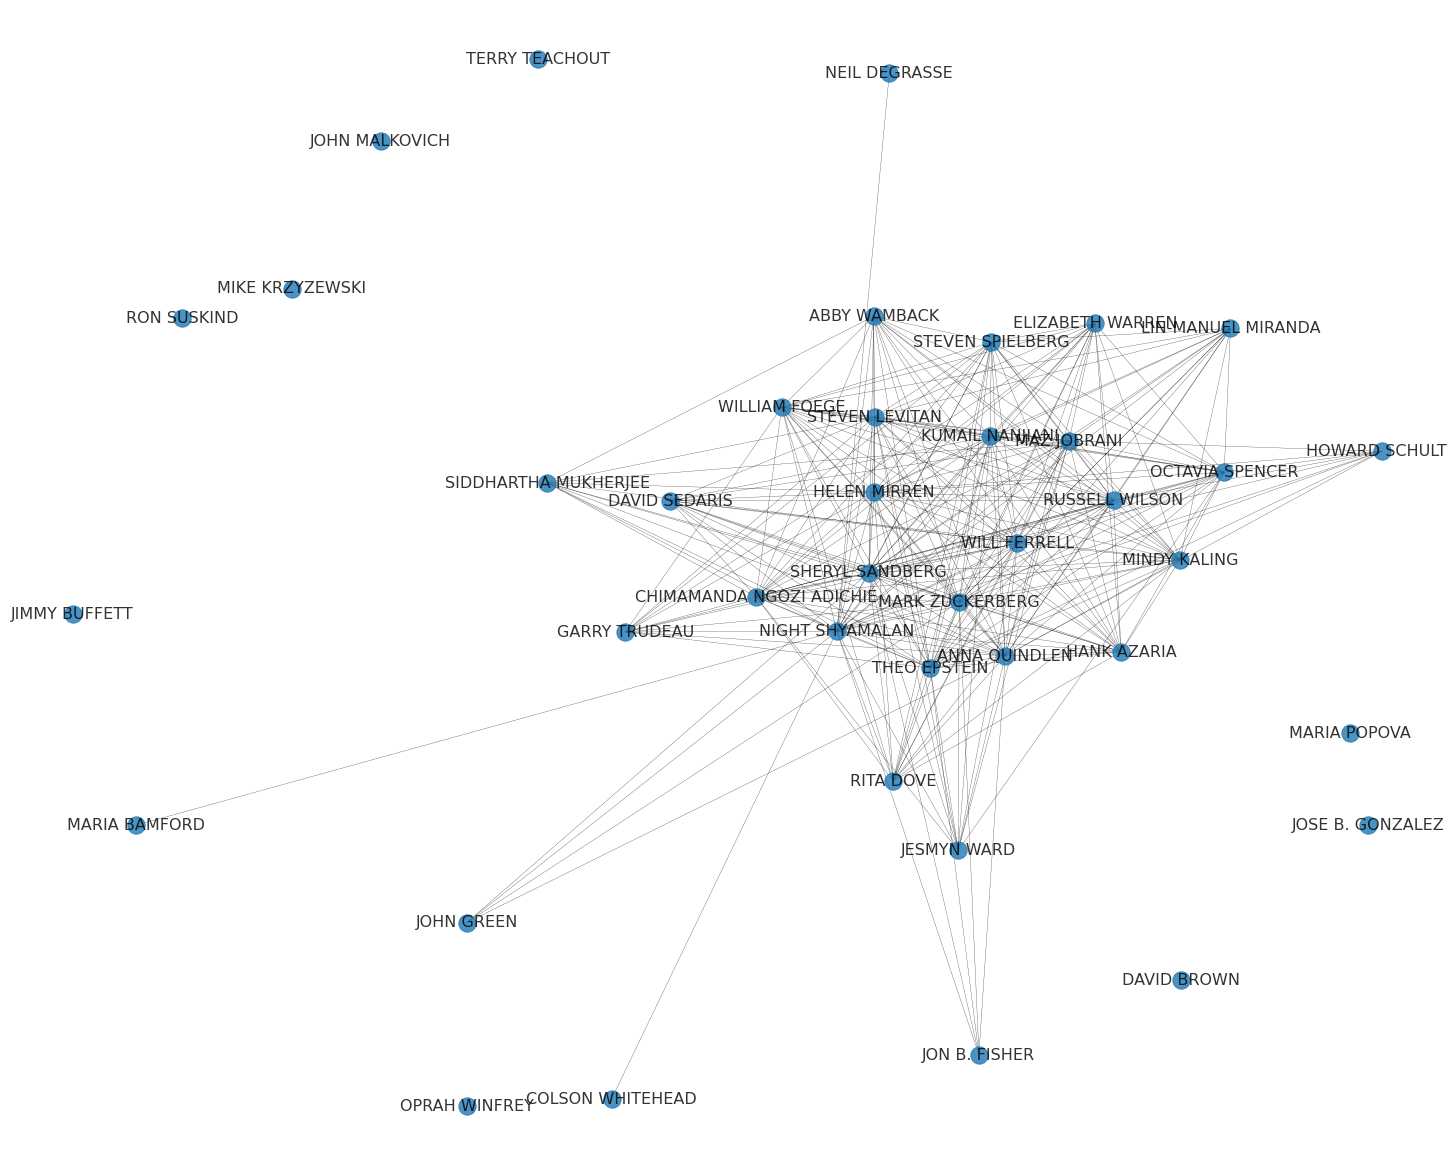

In [279]:
G = nx.Graph()

# Create nodes and edges
for node in node_list:
    G.add_node(node)
for edge, weight in speaker_word_assoc.items():
    if weight != 0:
        G.add_edge(edge[0], edge[1], weight=weight)
        
# Draw
plt.rcParams['figure.figsize'] = [20, 16]
pos = nx.spring_layout(G, iterations=50, scale=2, k=0.8)             # position of nodes
nx.draw(G, pos, with_labels=True, font_size=16,                         # node label
#             node_color=node_label, cmap='Pastel1',                          # node colorr
#             nodelist = node_list, node_size=[v*6000 for v in node_label],  # mode size
            width=.3, alpha=0.8,                                            # edge width and transparency
            )

### 2. Add attributes
Color the nodes (speakers) based on category of profession and age group.

In [137]:
# # Add attribute ('profession') for node color
# num_professions = 4
# interval = num_rows // num_professions
# for n, d in list(G.nodes(data=True))[:interval]:
#     G.nodes[n]['profession'] = 'Education'
# for n, d in list(G.nodes(data=True))[interval:interval*2]:
#     G.nodes[n]['profession'] = 'Entertainment'
# for n, d in list(G.nodes(data=True))[interval*2:interval*3]:
#     G.nodes[n]['profession'] = 'Tech'
# for n, d in list(G.nodes(data=True))[interval*3:]:
#     G.nodes[n]['profession'] = 'Publishing'

# # Assign values to 'type' (if want to use 'type' as node size partition)
# types = ['Education','Entertainment','Tech','Publishing']
# mapping = {'Education':1, 'Entertainment':2,'Tech':3,'Publishing':4}
# nodes = G.nodes()
# node_label = [mapping[G.nodes[n]['profession']] for n in nodes]

# # Draw
# plt.rcParams['figure.figsize'] = [20, 16]
# pos = nx.spring_layout(G, iterations=20, scale=2, k=0.8)             # position of nodes
# nx.draw(G, pos, with_labels=True, font_size=12,                         # node label
#         node_color=node_label, cmap='Pastel1',                          # node colorr
#         nodelist = node_list, node_size=500,
# #         [v*6000 for v in node_label],  # mode size
#         width=.1, alpha=1,                                            # edge width and transparency
#         )

# # Memorize the node positions from basic plot
# pos_want = pos

### A. Category (of profession) 
node_label from 'category'

In [123]:
df.head()

,transcript,category,age,age_then,transcript_clean
SIDDHARTHA MUKHERJEE,I wish someone had told me at my own commenc...,Med/Law,50,48,I wish told commencement requirement graduat...
JESMYN WARD,Persist. Be patient. Be well. Good morning....,Publish,43,41,Persist. Be patient. Be well. Good morning....
DAVID SEDARIS,"Thank you so much for having me, and for prese...",Entertainment,64,62,"Thank having me, presenting honorary degree. I..."
NIGHT SHYAMALAN,\nwhat's up dragons alright let's start\n\nwit...,Entertainment,50,48,\nwhat's dragons alright let's start\n\nwith g...
TERRY TEACHOUT,"I’m supposed to keep it short, and I approve o...",Publish,65,63,"I’m supposed short, I approve that. Being dram..."


In [280]:
first20 = df.iloc[:num_rows]

# Add attribute ('profession') for node color
num_professions = 4
interval = num_rows // num_professions

for n, d in list(G.nodes(data=True)):
    G.nodes[n]['category'] = first20.loc[n].category


# Assign values to 'type' (if want to use 'type' as node size partition)
types = df.category.unique().tolist()
mapping = {category_name: i for i, category_name in enumerate(types)}
nodes = G.nodes()
node_label = [mapping[G.nodes[n]['category']] for n in nodes]

In [281]:
# # Basic plot
# # Draw
# plt.rcParams['figure.figsize'] = [20, 16]
# pos = nx.spring_layout(G, iterations=20, scale=2, k=0.8)             # position of nodes
# nx.draw(G, pos, with_labels=True, font_size=12,                         # node label
#         node_color=node_label, cmap='Pastel1',                          # node colorr
#         nodelist = node_list, node_size=500,
# #         [v*6000 for v in node_label],  # mode size
#         width=.1, alpha=1,                                            # edge width and transparency
#         )

# # Memorize the node positions from basic plot
# pos_want = pos

In [301]:
# pos_want_40 = pos

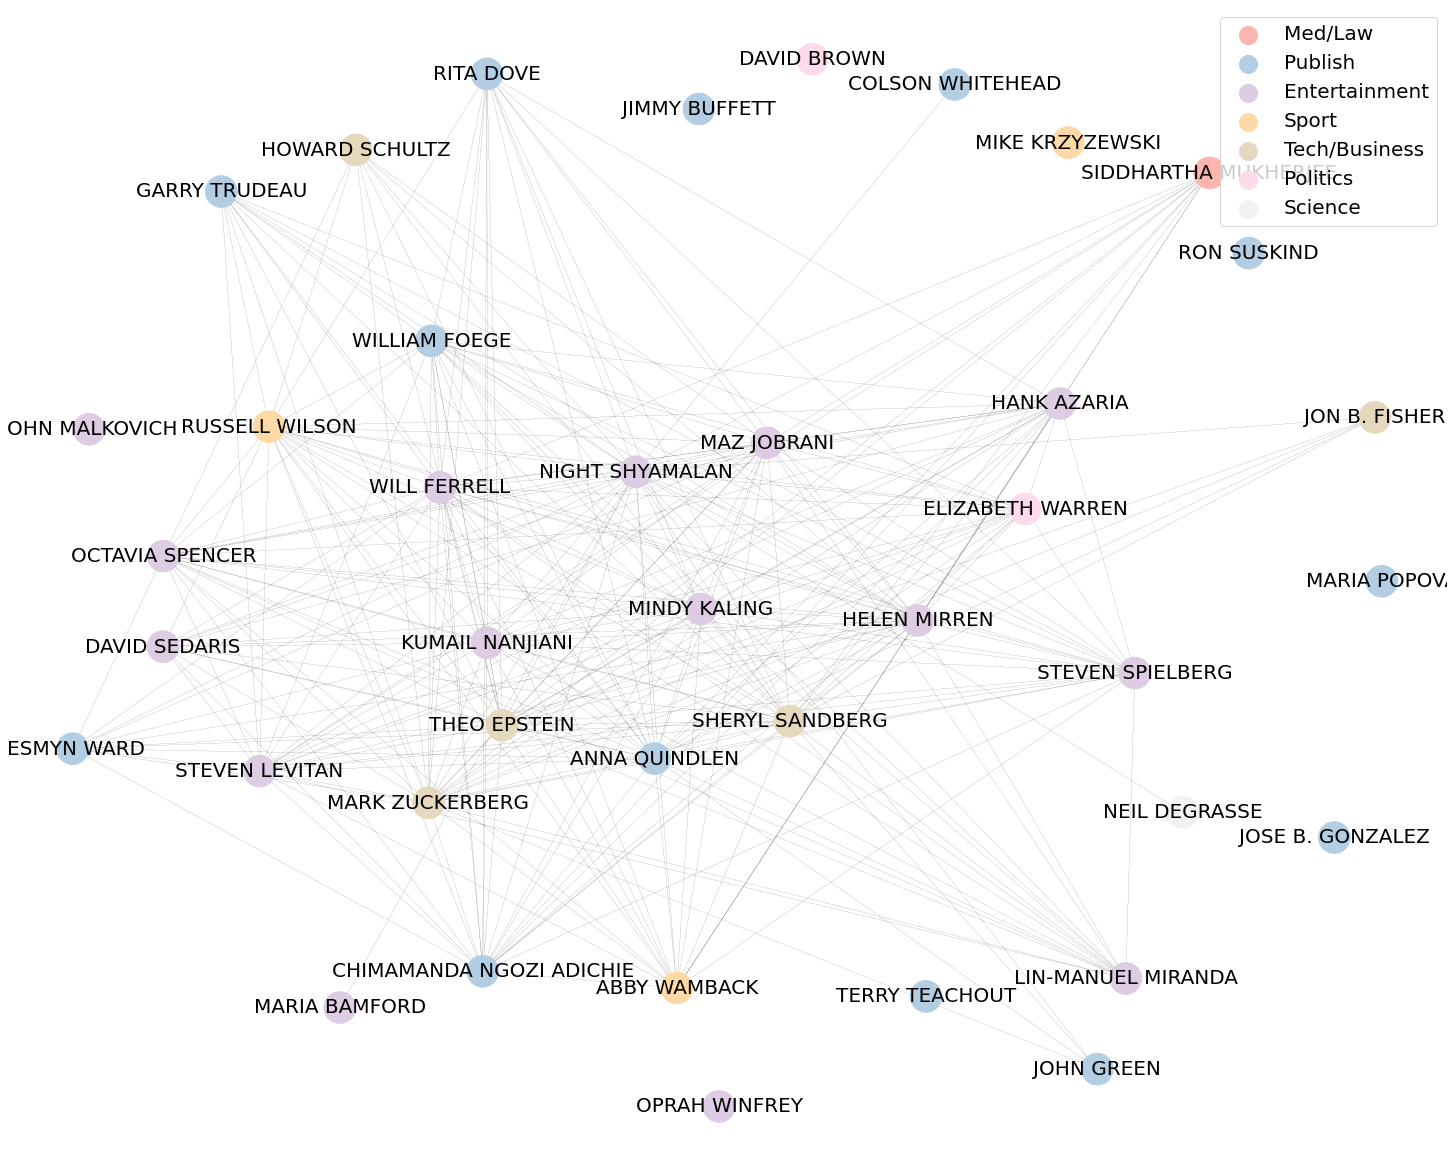

In [295]:
# With legend
plt.rcParams['figure.figsize'] = [20, 16]
pos = nx.spring_layout(G, iterations=20, scale=1, k=0.8)             # position of nodes
nx.draw(G, pos, with_labels=True, font_size=20,                         # node label
        node_color=node_label, cmap='Pastel1',                          # node colorr
        nodelist = node_list, node_size=1000,
#         [v*6000 for v in node_label],  # mode size
        width=.1, alpha=1,                                            # edge width and transparency
        )

pos_want = pos

# Includ legend
cmap = plt.get_cmap('Pastel1')
maxval = np.max(node_label) 
[cmap(v/maxval) for v in node_label]
for v in set(node_label):
    plt.scatter([],[], c=[cmap(v/maxval)], label=types[v])
plt.legend(markerscale=3, prop={'size': 20});

### B. Age of speaker

In [254]:
df['age_cat'] = df['age_then'].apply(lambda x: str(x//10)+'0-'+str(x//10 + 1)+'0')

In [297]:
first20 = df.iloc[:num_rows]

# Add attribute ('profession') for node color

for n, d in list(G.nodes(data=True)):
    G.nodes[n]['age_cat'] = first20.loc[n].age_cat


# Assign values to 'type' (if want to use 'type' as node size partition)
types = sorted(df.age_cat.unique().tolist())
mapping = {category_name: i for i, category_name in enumerate(types)}
nodes = G.nodes()
node_label = [mapping[G.nodes[n]['age_cat']] for n in nodes]

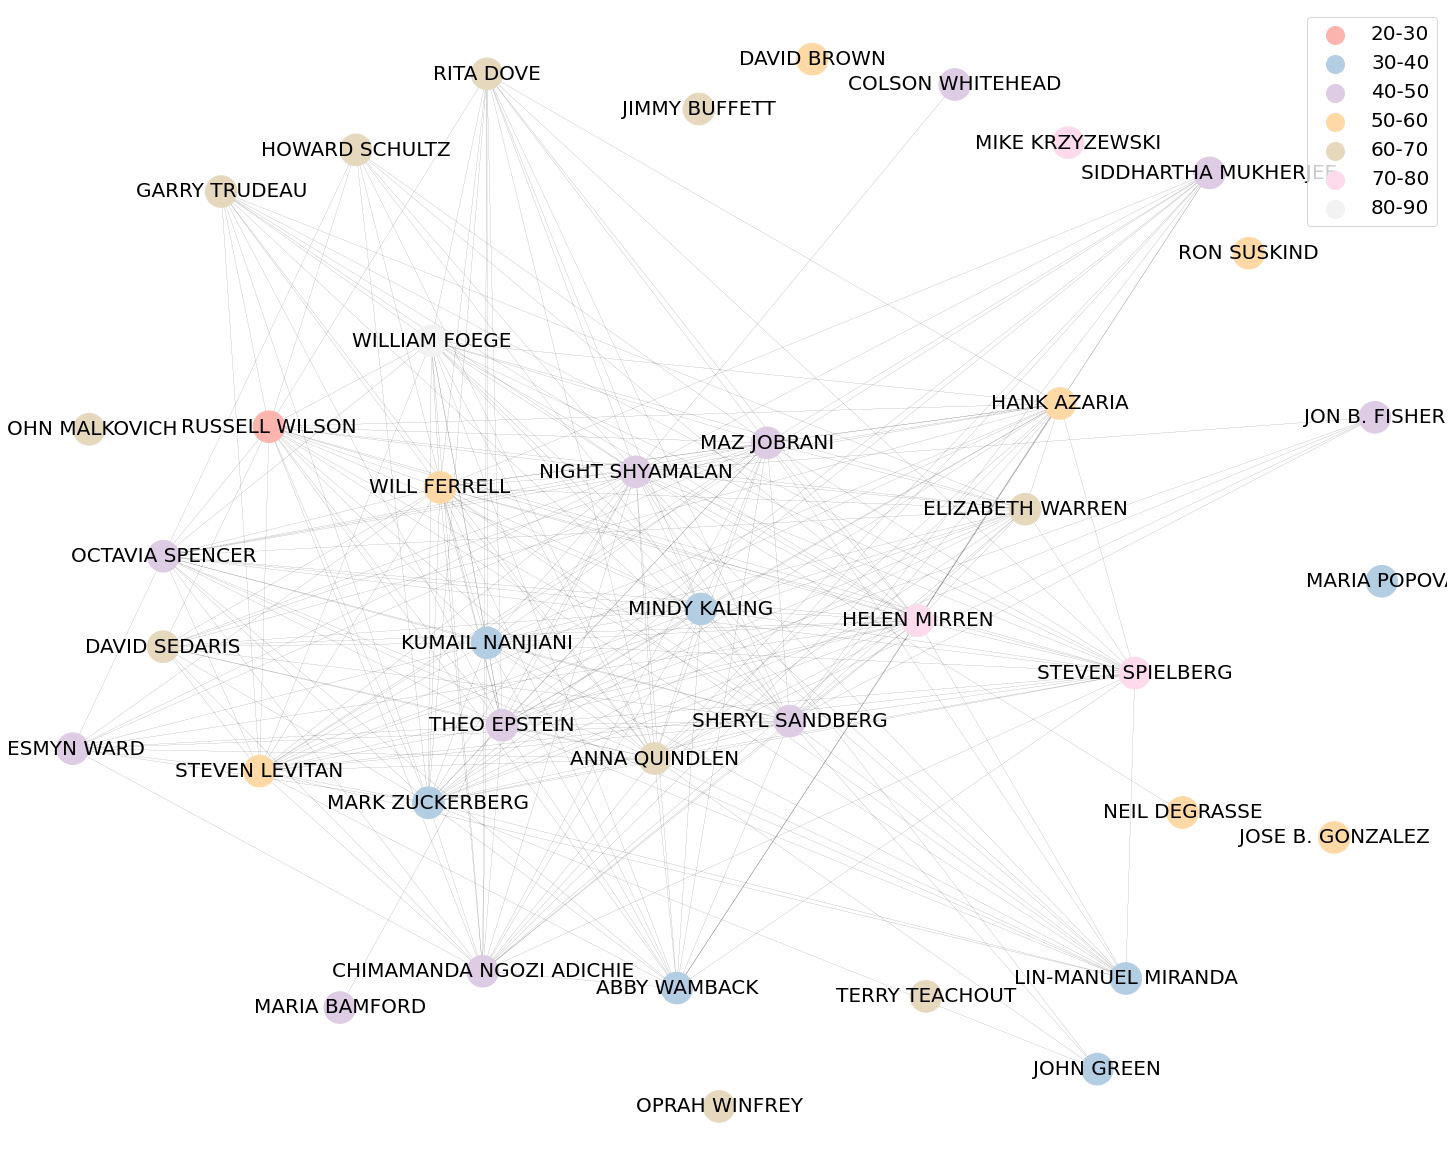

In [298]:
# With legend
plt.rcParams['figure.figsize'] = [20, 16]
pos = nx.spring_layout(G, iterations=20, scale=1, k=0.8)             # position of nodes
nx.draw(G, pos=pos_want, with_labels=True, font_size=20,                         # node label
        node_color=node_label, cmap='Pastel1',                          # node colorr
        nodelist = node_list, node_size=1000,
#         [v*6000 for v in node_label],  # mode size
        width=.1, alpha=1,                                            # edge width and transparency
        )

# Includ legend
cmap = plt.get_cmap('Pastel1')
maxval = np.max(node_label) 
[cmap(v/maxval) for v in node_label]
for v in set(node_label):
    plt.scatter([],[], c=[cmap(v/maxval)], label=types[v])
plt.legend(markerscale=3, prop={'size': 20});

### C. Label from NMF clustering

In [39]:
speaker_label.head()

,label,speaker
0,5,SIDDHARTHA MUKHERJEE
1,2,ABBY WAMBACK
2,2,JON B. FISHER
3,3,MINDY KALING
4,2,JESMYN WARD


In [38]:
speaker_label_first20 = speaker_label.iloc[:20]
speaker_label_first20.index = speaker_label_first20.speaker

In [47]:
speaker_label_first20

,label,speaker
speaker,,
SIDDHARTHA MUKHERJEE,5,SIDDHARTHA MUKHERJEE
ABBY WAMBACK,2,ABBY WAMBACK
JON B. FISHER,2,JON B. FISHER
MINDY KALING,3,MINDY KALING
JESMYN WARD,2,JESMYN WARD
NIGHT SHYAMALAN,2,NIGHT SHYAMALAN
GEORGE C MARSHALL,5,GEORGE C MARSHALL
DAVID SEDARIS,3,DAVID SEDARIS
MARIA BAMFORD,3,MARIA BAMFORD


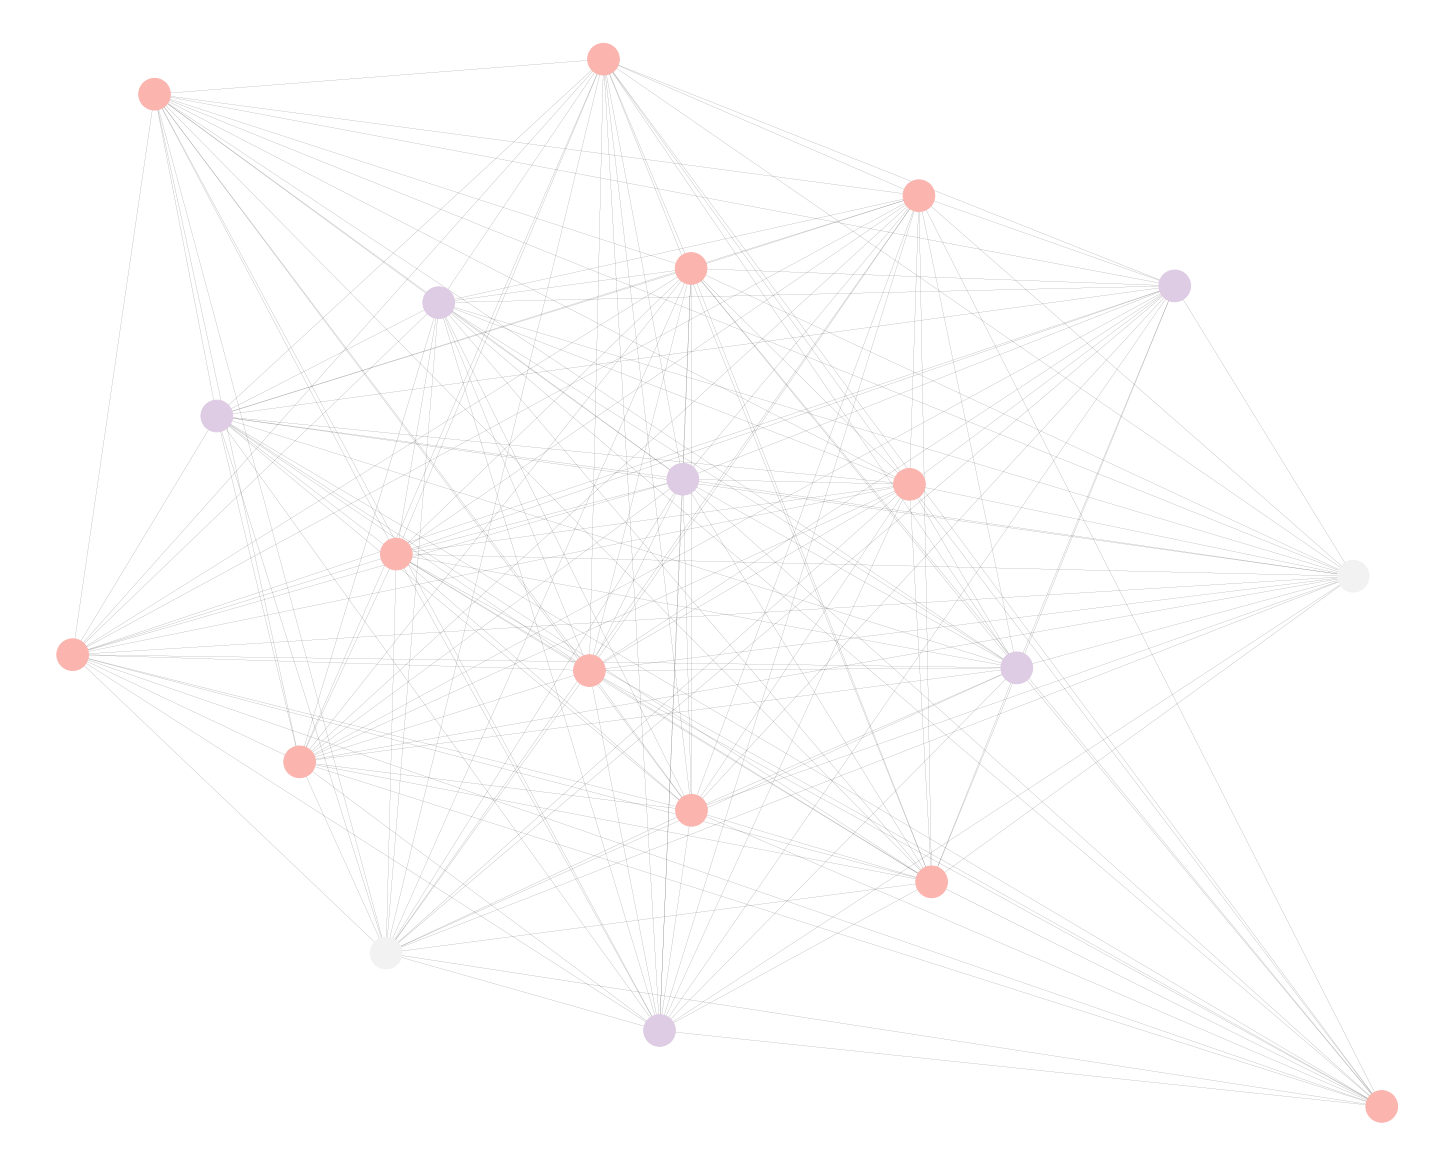

In [41]:
# Add attribute ('label') for node color
num_professions = 4
interval = num_rows // num_professions
for n, d in list(G.nodes(data=True)):
    G.nodes[n]['label'] = speaker_label_first20.loc[n].label


# Assign values to 'type' (if want to use 'type' as node size partition)
types = ['Education','Entertainment','Tech','Publishing']
mapping = {'Education':1, 'Entertainment':2,'Tech':3,'Publishing':4}
nodes = G.nodes()
node_label = [G.nodes[n]['label'] for n in nodes]

# Draw
plt.rcParams['figure.figsize'] = [20, 16]
pos = nx.spring_layout(G, iterations=20, scale=2, k=0.8)             # position of nodes
nx.draw(G, pos, with_labels=False, font_size=12,                         # node label
        node_color=node_label, cmap='Pastel1',                          # node colorr
        nodelist = node_list, node_size=1000,
#         [v*6000 for v in node_label],  # mode size
        width=.1, alpha=1,                                            # edge width and transparency
        )

# Memorize the node positions from basic plot
pos_want = pos